<h4>Install prophet + plotly for interactive plotting (interactive plots are laggy)

In [1]:
!pip install prophet

In [2]:
!pip install plotly

In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

f2021 = "../IT-NO_2021_hourly.csv"
f2022 = "../IT-NO_2022_hourly.csv"
f2023 = "../IT-NO_2023_hourly.csv"

dataset1 = pd.read_csv(f2021)
dataset2 = pd.read_csv(f2022)
dataset3 = pd.read_csv(f2023)

Some useful functions to plot and print graphs:

In [4]:
def plotting_comparison(dataset_CI, forecast):
    # datapoints:
    x1 = dataset_CI['ds']
    y1 = dataset_CI['y']
    x2 = forecast['ds']
    y2 = forecast['yhat']

    fig = plt.figure(figsize=(40, 15))  # Adjust the figure size as needed
    plt.rc("font", weight="bold", size=15)

    # Create the first subplot
    ax1 = fig.add_subplot(3, 1, 1)  # This will be the first subplot (3 rows, 1 column, first plot)
    ax1.grid(True)
    ax1.plot(x1, y1, 'red', label = '(LCA+direct) - Real Values')
    ax1.set_ylim(0, 1250)

    # Create the second subplot
    ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)  # This will be the second subplot
    ax2.grid(True)
    ax2.plot(x2, y2, 'blue', label = '(LCA+direct) - Prophet prediction from 2023-07')
    ax2.set_ylim(0, 1250)

    # Create the third subplot for Prophet's plot
    ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)  # This will be the third subplot
    fig1 = m.plot(forecast, ax=ax3)  # Plot the forecast on the third subplot

    ax3.plot(x1, y1, 'red', label = '(LCA+direct) - Real Values')

    ax3.set_xlabel('Date')  # Set the x-axis label
    ax3.set_ylabel('Forecast')  # Set the y-axis label
    ax3.tick_params(axis='x')  # Optional: Rotate x-axis labels for better readability

    ax1.legend()
    ax2.legend()
    ax3.legend()

    for ax in fig.get_axes():
        ax.set_title(ax.get_title(), fontweight='bold', fontsize=15)
        ax.set_ylabel(ax.get_ylabel(), fontweight='bold', fontsize=15)

    plt.tight_layout()  # Adjust the layout so that plots do not overlap
    plt.show()  # Display the figure

def plotting_error(dataset_zoom):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10))
    plt.rc("font", weight="bold", size=15)

    # Plot line1 and line2 on the first subplot
    dataset_zoom['Real Values'].plot(ax=ax1, label='Real Values')
    dataset_zoom['Prediction'].plot(ax=ax1, label='Prediction')
    ax1.set_title('Carbon Intensity prediction')  # Set title for the first subplot
    ax1.set_xlabel('')  # Set x-axis label for the first subplot
    ax1.set_ylabel('Carbon Intensity')  # Set y-axis label for the first subplot
    ax1.grid(True)  # Turn on grid for the first subplot
    ax1.legend()

    # Plot line3 on the second subplot
    dataset_zoom['% ERR'].plot(ax=ax2, color = 'red', label = 'percentage (%) difference')
    ax2.set_title('Percentage error')  # Set title for the second subplot
    ax2.set_xlabel('')  # Set x-axis label for the second subplot
    ax2.set_ylabel('% Error')  # Set y-axis label for the second subplot
    ax2.grid(True)  # Turn on grid for the second subplot
    ax2.legend()
    # Adjust layout
    plt.tight_layout()

    for ax in fig.get_axes():
        ax.set_title(ax.get_title(), fontweight='bold', fontsize=15)
        ax.set_ylabel(ax.get_ylabel(), fontweight='bold', fontsize=15)

    # Show the plots
    plt.show()

    

                     LCA+direct
timestamp                      
2021-01-01 00:00:00      693.03
2021-01-01 01:00:00      691.21
2021-01-01 02:00:00      672.90
2021-01-01 03:00:00      675.92
2021-01-01 04:00:00      702.72


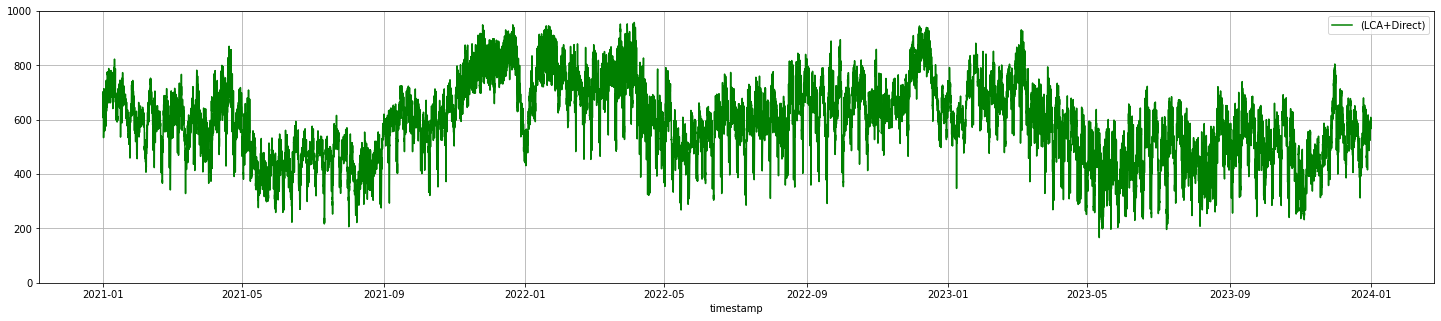

In [5]:
# Data concatenation of carbon intensity:
dataset_CI = pd.concat([dataset1, dataset2, dataset3], axis=0)
dataset_CI['Datetime (UTC)'] = pd.to_datetime(dataset_CI['Datetime (UTC)'])
dataset_CI.rename(columns={'Datetime (UTC)': 'timestamp'}, inplace=True) # Column renaming
dataset_CI.set_index('timestamp', inplace=True)
dataset_CI.drop(columns=['Country', 'Zone Name', 'Zone Id', 'Data Source', 'Data Estimated', 'Data Estimation Method', 'Low Carbon Percentage', 'Renewable Percentage'], inplace=True)
dataset_CI['LCA+direct'] = dataset_CI['Carbon Intensity gCO₂eq/kWh (LCA)'] + dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)']
dataset_CI.drop(columns=['Carbon Intensity gCO₂eq/kWh (direct)', 'Carbon Intensity gCO₂eq/kWh (LCA)'], inplace=True)
print(dataset_CI.head())

# Plotting and comparison od the different CI values
x = dataset_CI.index
y = dataset_CI['LCA+direct']

# Create subplots with shared X-axis
fig, ax1 = plt.subplots(1, 1, figsize=(25, 5), sharex=True)

# Plot data on each subplot
ax1.grid(True)
ax1.plot(x, y, 'g', label='(LCA+Direct)')
ax1.set_ylim(0, 1000)
ax1.set_xlabel('timestamp')

# Add legends
ax1.legend()

# Show the plot
plt.show()

Testing prophet on LCA+direct datapoints. documentation: https://facebook.github.io/prophet/docs/quick_start.html#python-api
 

Preparing the dataframe as required by the prophet documentation:

In [6]:
dataset_CI_fix = dataset_CI.reset_index()
dataset_CI_fix.rename(columns={'timestamp':'ds', 'LCA+direct':'y' }, inplace=True)
print(dataset_CI_fix.tail())

                       ds       y
26275 2023-12-31 19:00:00  594.23
26276 2023-12-31 20:00:00  608.81
26277 2023-12-31 21:00:00  574.62
26278 2023-12-31 22:00:00  597.98
26279 2023-12-31 23:00:00  570.99


In [7]:
dataset_CI_fix.tail()

,ds,y
26275,2023-12-31 19:00:00,594.23
26276,2023-12-31 20:00:00,608.81
26277,2023-12-31 21:00:00,574.62
26278,2023-12-31 22:00:00,597.98
26279,2023-12-31 23:00:00,570.99


### Training using the different time periods: 


In [8]:
dataset_30m = dataset_CI_fix[(dataset_CI_fix['ds'] < '2023-07')] # 2.5 years of data = 30 months
dataset_28m = dataset_30m[(dataset_30m['ds'] > '2021-03')]
dataset_26m = dataset_28m[(dataset_28m['ds'] > '2021-05')]
dataset_24m = dataset_26m[(dataset_26m['ds'] > '2021-07')]
dataset_22m = dataset_24m[(dataset_24m['ds'] > '2021-09')]
dataset_20m = dataset_22m[(dataset_22m['ds'] > '2021-11')]
dataset_18m = dataset_20m[(dataset_20m['ds'] > '2022-01')]
dataset_16m = dataset_18m[(dataset_18m['ds'] > '2022-03')]
dataset_14m = dataset_16m[(dataset_16m['ds'] > '2022-05')]
dataset_12m = dataset_14m[(dataset_14m['ds'] > '2022-07')] 
dataset_10m = dataset_12m[(dataset_12m['ds'] > '2022-09')] 
dataset_8m = dataset_10m[(dataset_10m['ds'] > '2022-11')] 
dataset_6m = dataset_8m[(dataset_8m['ds'] > '2023-01')] # 6 months of data

dataset_30m.name = "30 months"
dataset_28m.name = "28 months"
dataset_26m.name = "26 months" 
dataset_24m.name = "24 months"
dataset_22m.name = "22 months"
dataset_20m.name = "20 months"
dataset_18m.name = "18 months"
dataset_16m.name = "16 months"
dataset_14m.name = "14 months"
dataset_12m.name = "12 months"
dataset_10m.name = "10 months"
dataset_8m.name = "8 months"
dataset_6m.name = "6 months"

14:30:01 - cmdstanpy - INFO - Chain [1] start processing
14:30:36 - cmdstanpy - INFO - Chain [1] done processing


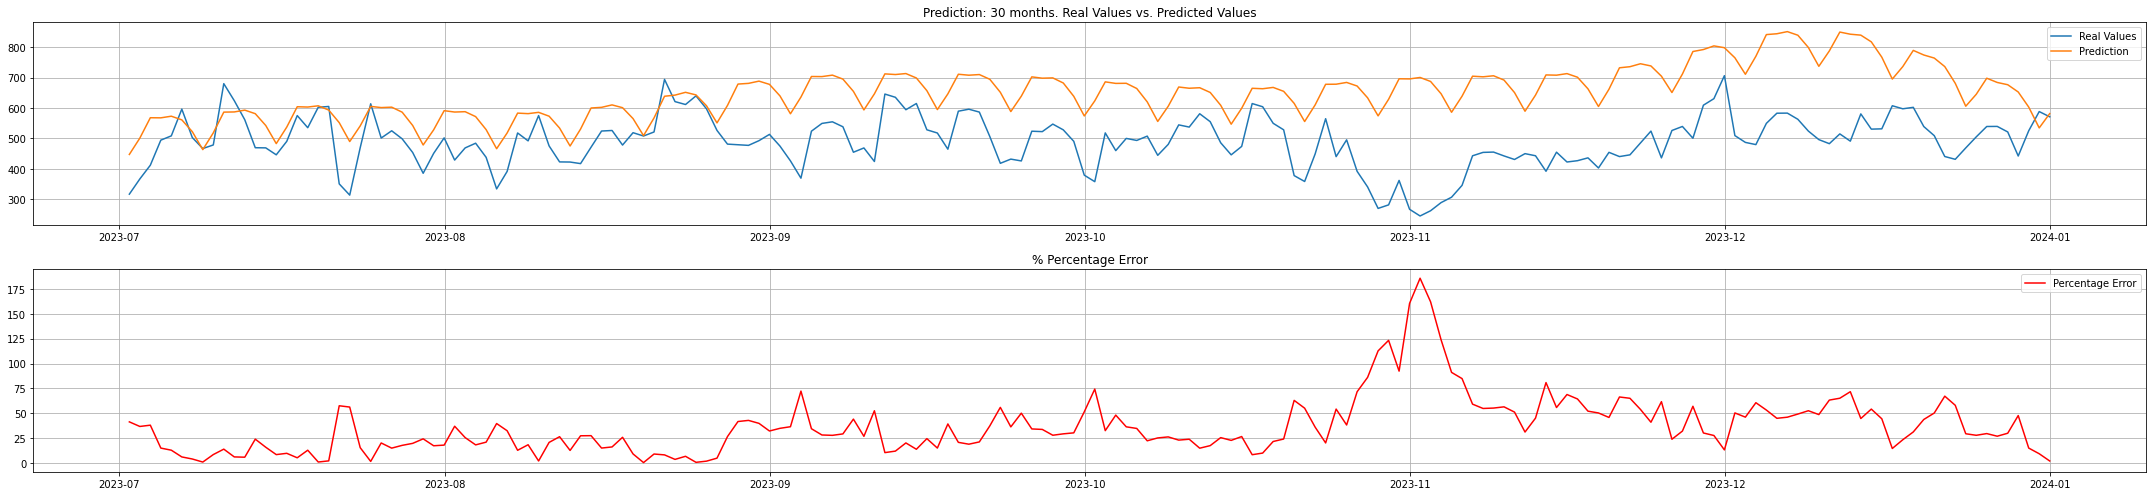


DATASET: 30 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 21.87                          
2 WEEKS:          %Mean.Abs.Perc.Err: 16.21                              
1 MONTH:          %Mean.Abs.Perc.Err: 16.96                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 17.61                             
6 MONTHS:          %Mean.Abs.Perc.Err: 36.45


14:30:49 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing


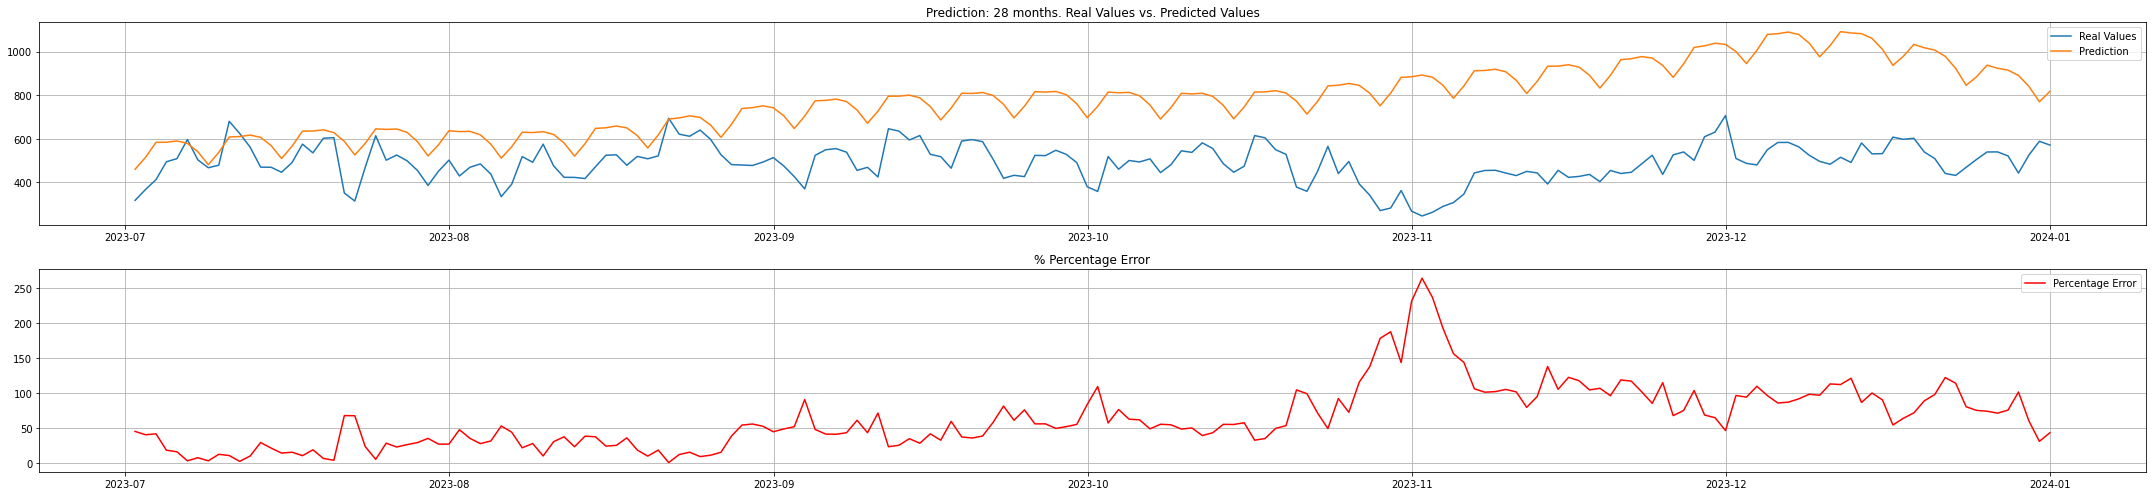


DATASET: 28 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 24.53                          
2 WEEKS:          %Mean.Abs.Perc.Err: 18.59                              
1 MONTH:          %Mean.Abs.Perc.Err: 22.05                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 24.94                             
6 MONTHS:          %Mean.Abs.Perc.Err: 64.09


14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:35 - cmdstanpy - INFO - Chain [1] done processing


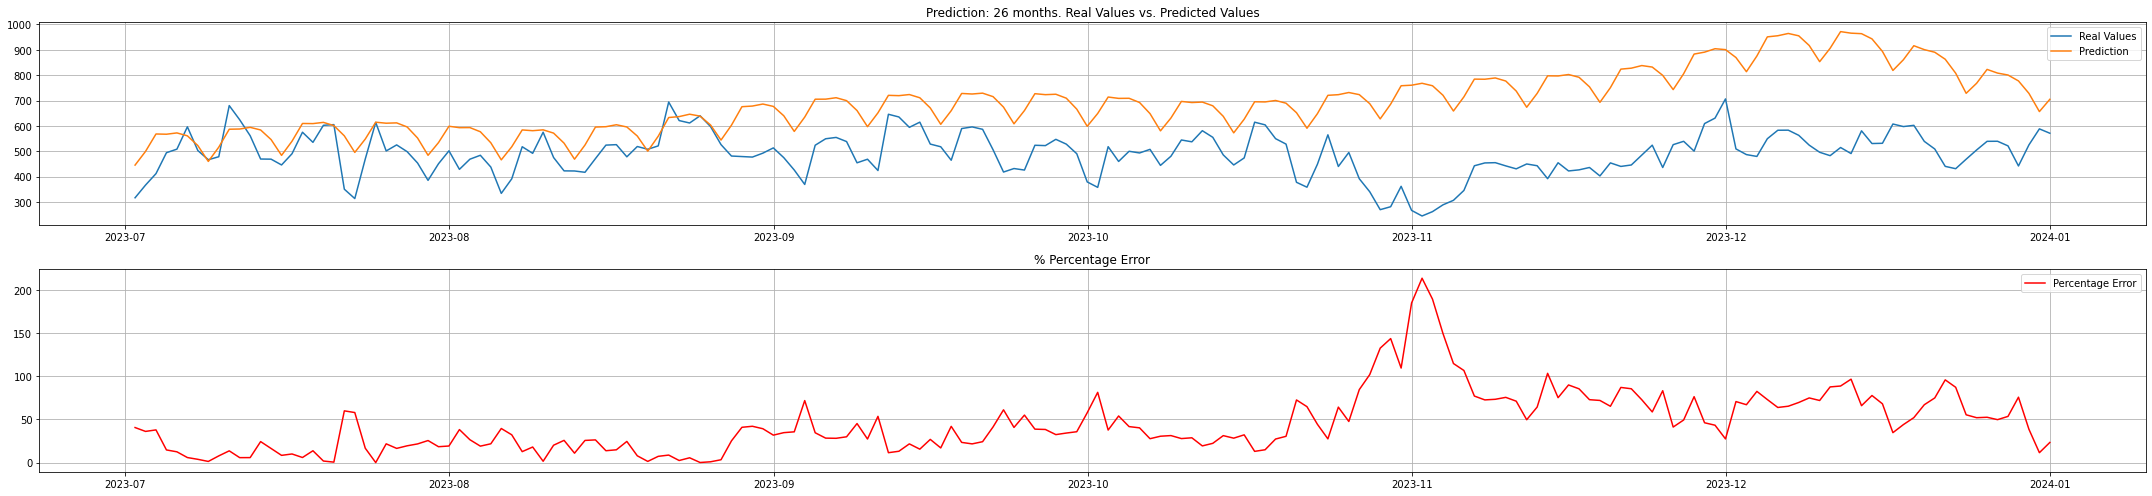


DATASET: 26 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 21.71                          
2 WEEKS:          %Mean.Abs.Perc.Err: 16.25                              
1 MONTH:          %Mean.Abs.Perc.Err: 17.57                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 17.76                             
6 MONTHS:          %Mean.Abs.Perc.Err: 45.47


14:31:41 - cmdstanpy - INFO - Chain [1] start processing
14:31:59 - cmdstanpy - INFO - Chain [1] done processing


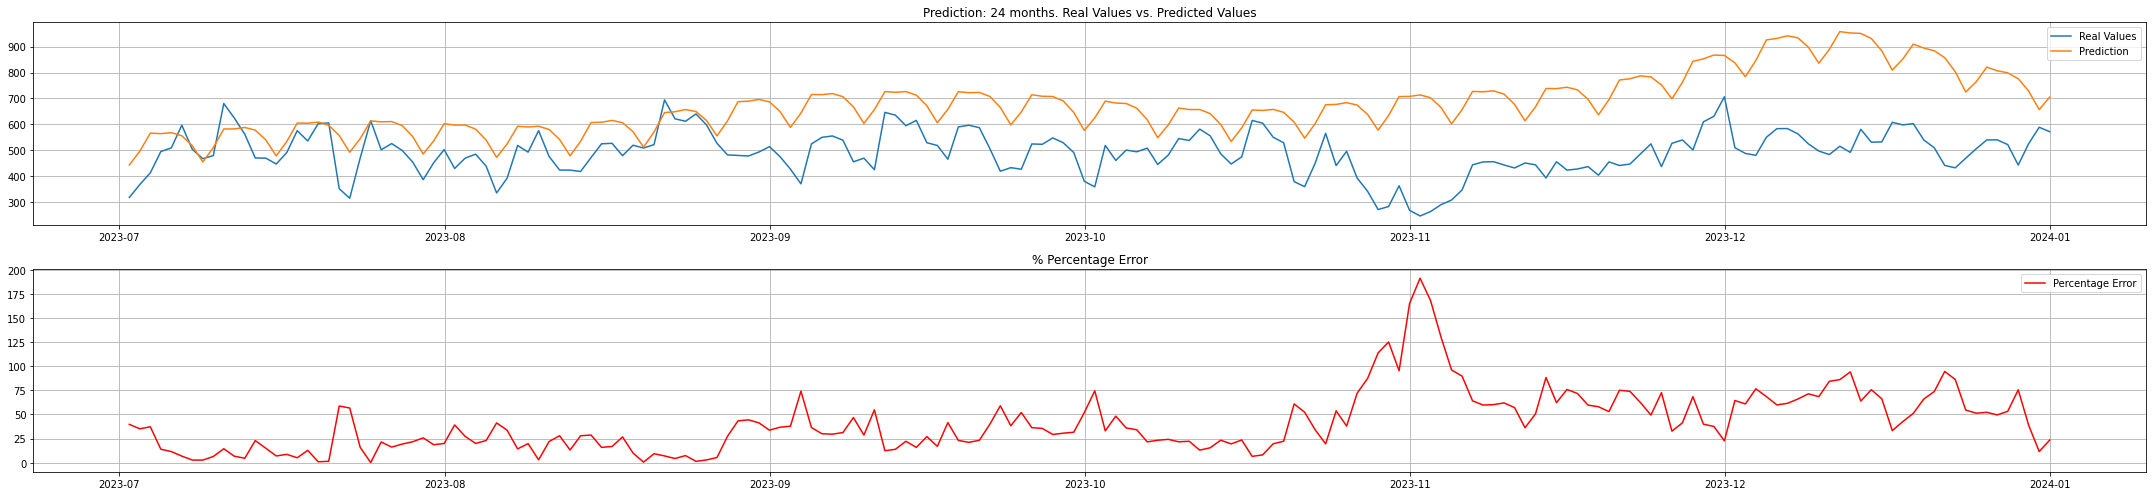


DATASET: 24 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 21.06                          
2 WEEKS:          %Mean.Abs.Perc.Err: 15.75                              
1 MONTH:          %Mean.Abs.Perc.Err: 17.05                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 18.27                             
6 MONTHS:          %Mean.Abs.Perc.Err: 41.54


14:32:05 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing


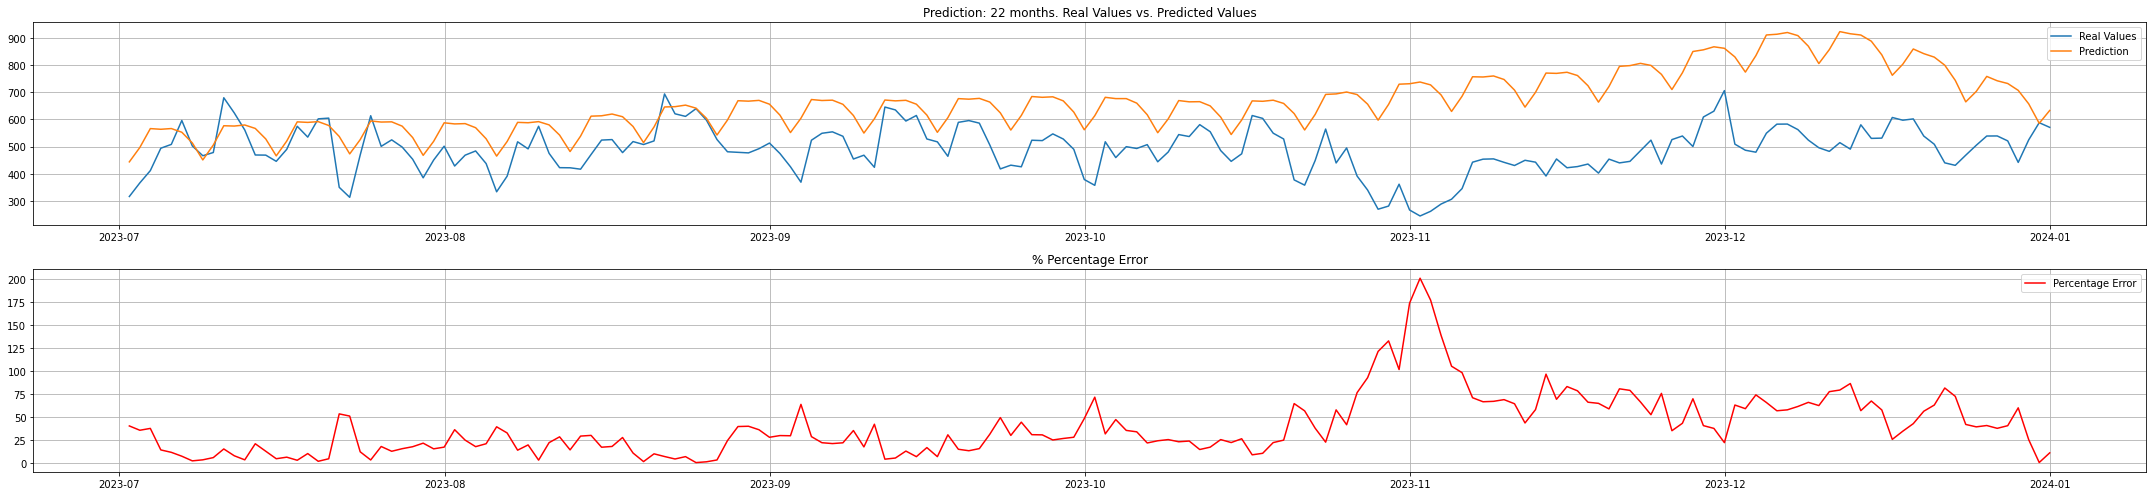


DATASET: 22 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 21.19                          
2 WEEKS:          %Mean.Abs.Perc.Err: 15.50                              
1 MONTH:          %Mean.Abs.Perc.Err: 15.55                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 17.10                             
6 MONTHS:          %Mean.Abs.Perc.Err: 39.70


14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:24 - cmdstanpy - INFO - Chain [1] done processing


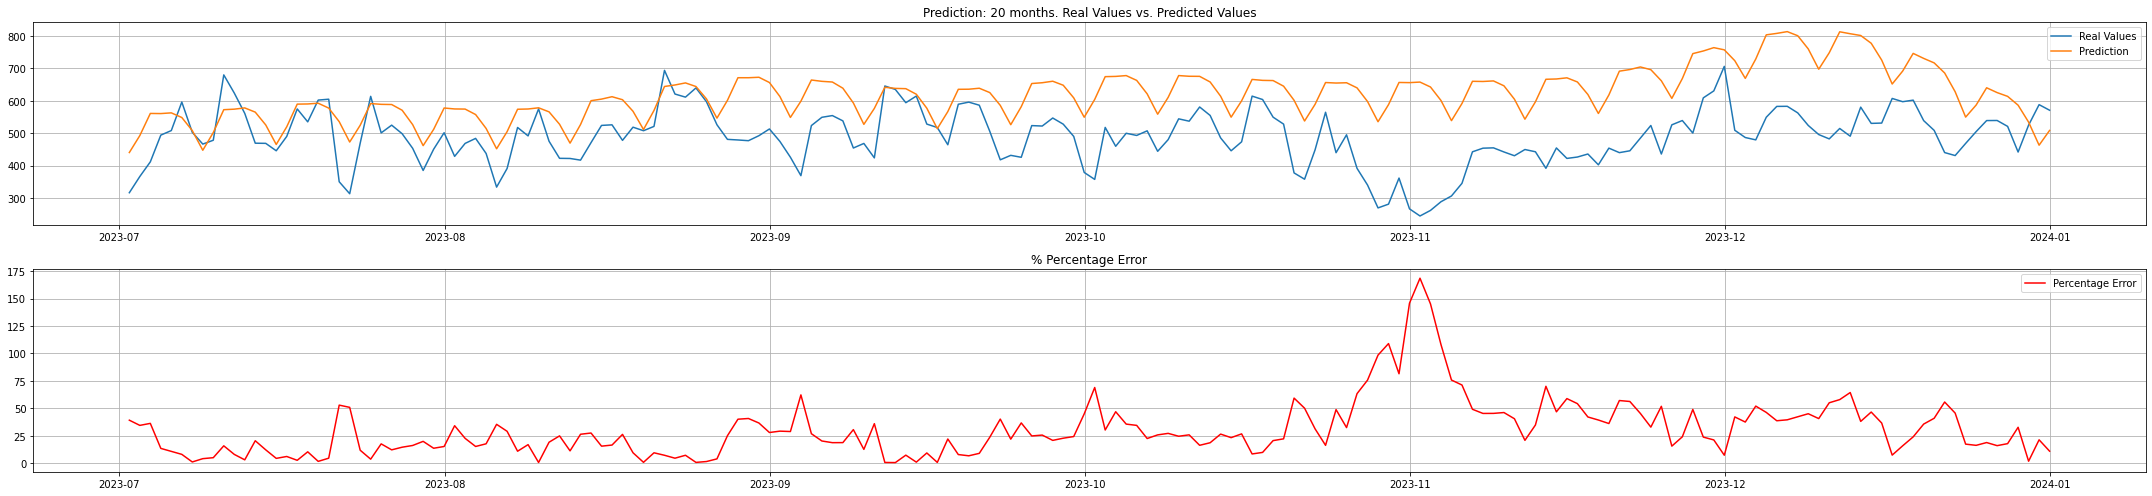


DATASET: 20 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 20.43                          
2 WEEKS:          %Mean.Abs.Perc.Err: 15.10                              
1 MONTH:          %Mean.Abs.Perc.Err: 15.12                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 16.14                             
6 MONTHS:          %Mean.Abs.Perc.Err: 30.61


14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:35 - cmdstanpy - INFO - Chain [1] done processing


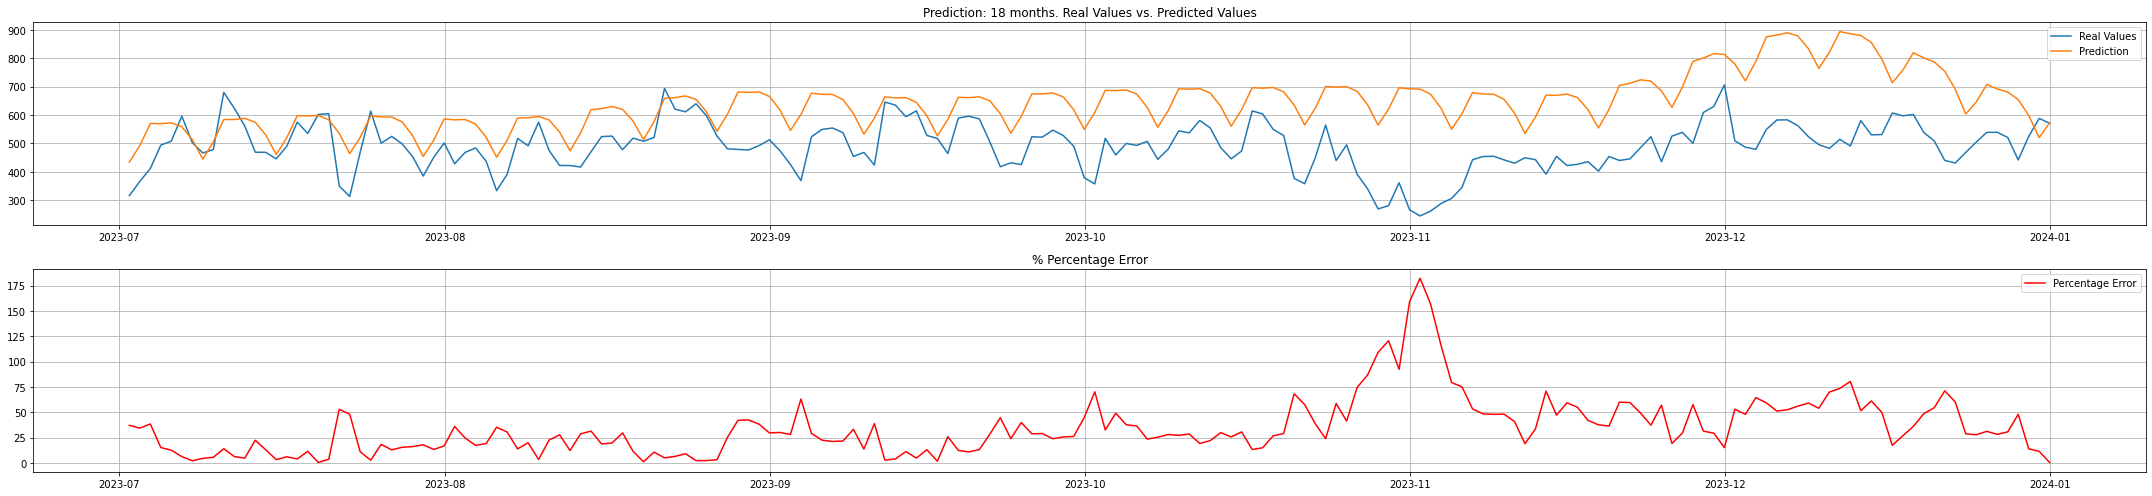


DATASET: 18 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 20.93                          
2 WEEKS:          %Mean.Abs.Perc.Err: 15.53                              
1 MONTH:          %Mean.Abs.Perc.Err: 15.20                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 17.11                             
6 MONTHS:          %Mean.Abs.Perc.Err: 34.96


14:32:40 - cmdstanpy - INFO - Chain [1] start processing
14:32:48 - cmdstanpy - INFO - Chain [1] done processing


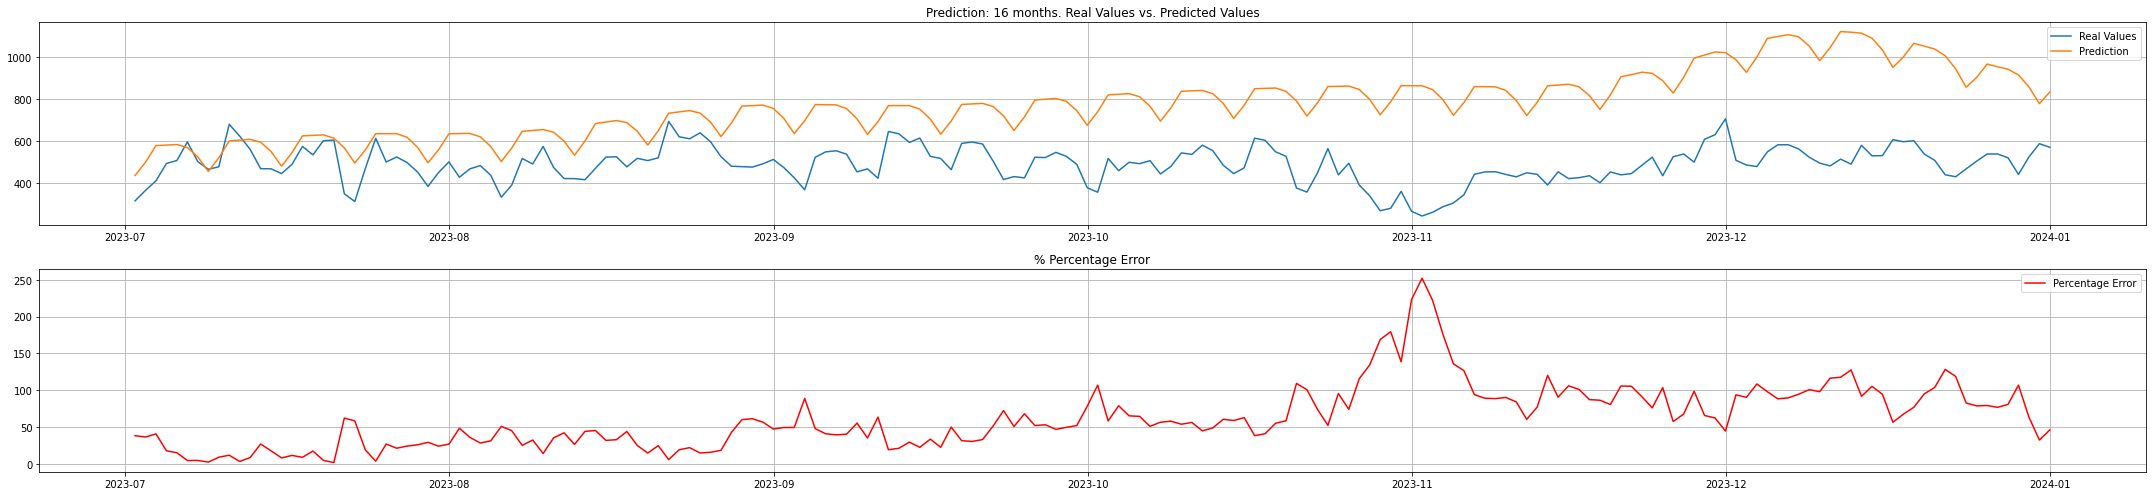


DATASET: 16 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 22.36                          
2 WEEKS:          %Mean.Abs.Perc.Err: 16.79                              
1 MONTH:          %Mean.Abs.Perc.Err: 19.34                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 25.68                             
6 MONTHS:          %Mean.Abs.Perc.Err: 62.26


14:32:52 - cmdstanpy - INFO - Chain [1] start processing
14:32:55 - cmdstanpy - INFO - Chain [1] done processing


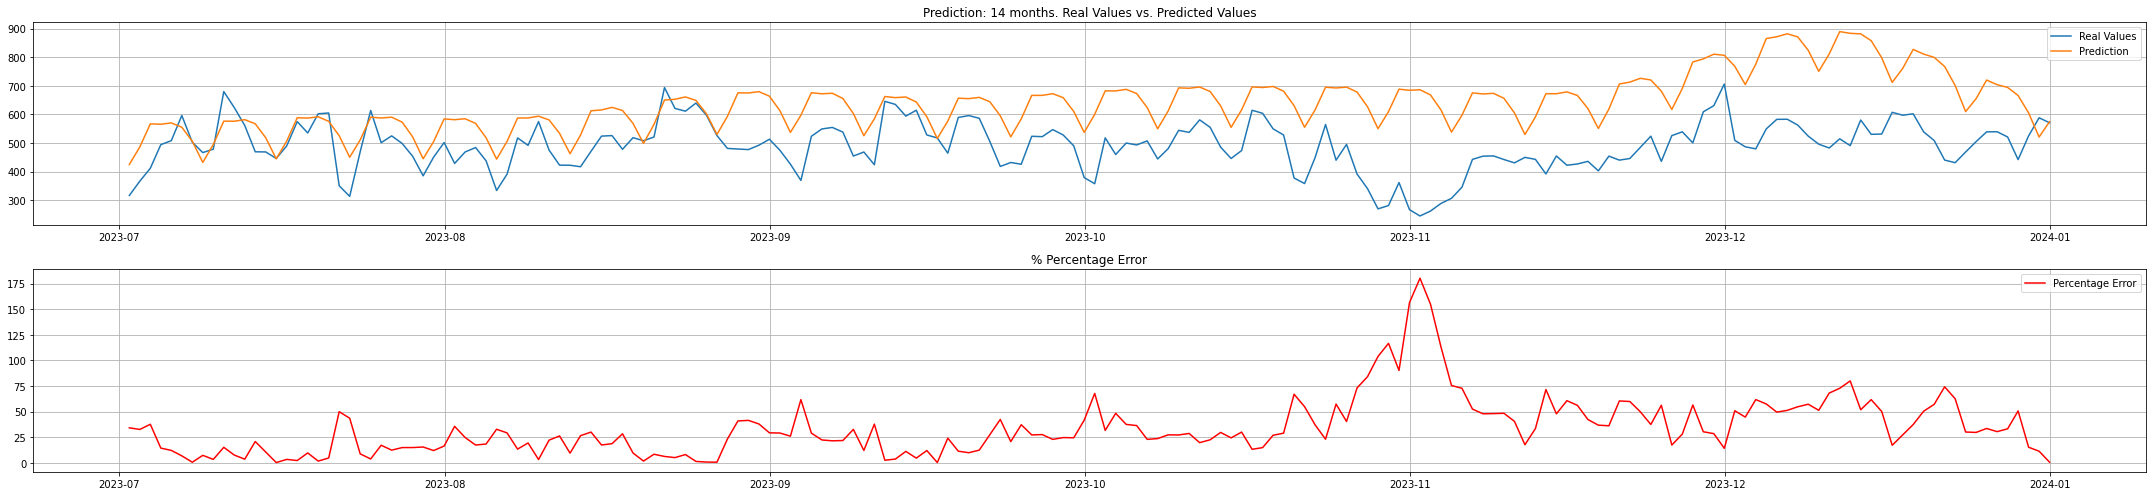


DATASET: 14 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 19.82                          
2 WEEKS:          %Mean.Abs.Perc.Err: 14.82                              
1 MONTH:          %Mean.Abs.Perc.Err: 14.11                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 16.03                             
6 MONTHS:          %Mean.Abs.Perc.Err: 34.14


14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing


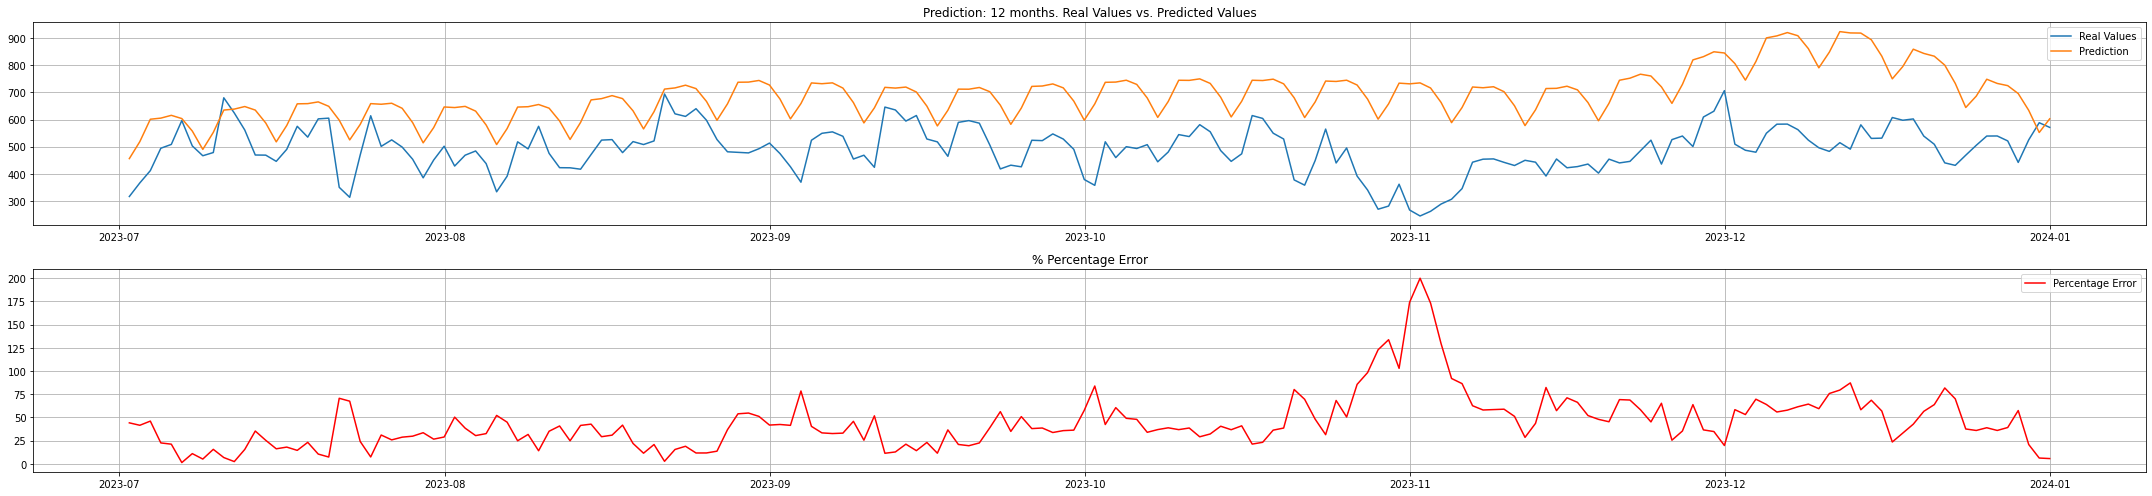


DATASET: 12 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 26.71                          
2 WEEKS:          %Mean.Abs.Perc.Err: 20.87                              
1 MONTH:          %Mean.Abs.Perc.Err: 24.17                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 27.18                             
6 MONTHS:          %Mean.Abs.Perc.Err: 44.51


14:33:03 - cmdstanpy - INFO - Chain [1] start processing
14:33:03 - cmdstanpy - INFO - Chain [1] done processing


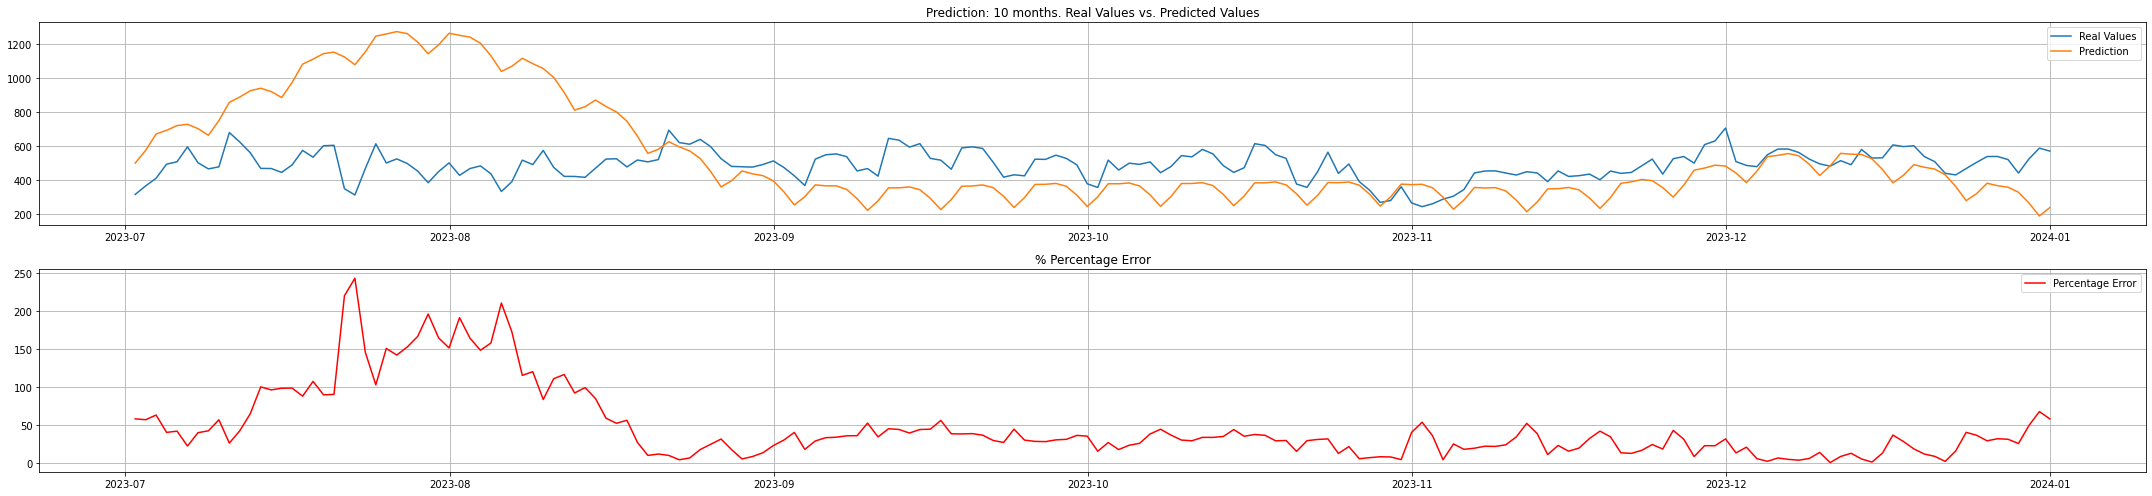


DATASET: 10 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 45.97                          
2 WEEKS:          %Mean.Abs.Perc.Err: 53.61                              
1 MONTH:          %Mean.Abs.Perc.Err: 100.34                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 89.53                             
6 MONTHS:          %Mean.Abs.Perc.Err: 47.17


14:33:06 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing


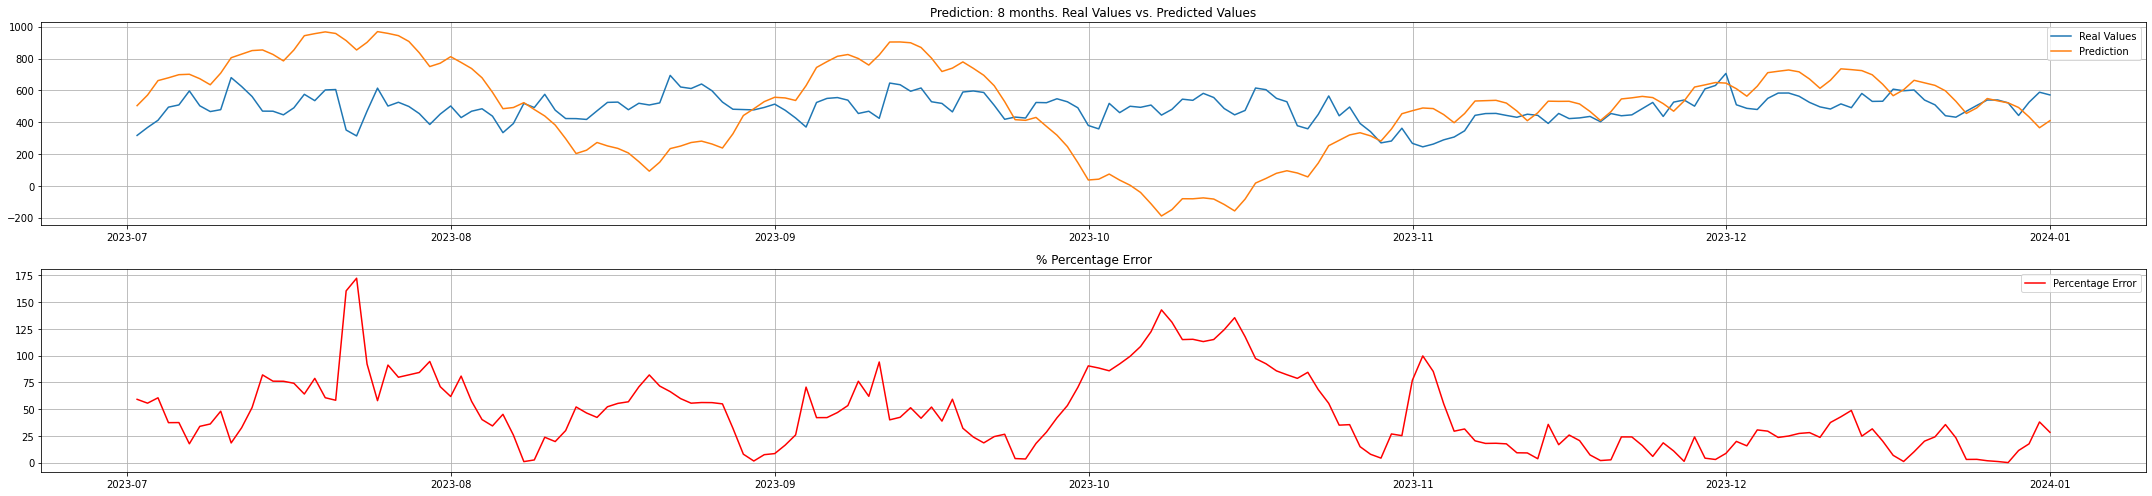


DATASET: 8 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 43.04                          
2 WEEKS:          %Mean.Abs.Perc.Err: 46.12                              
1 MONTH:          %Mean.Abs.Perc.Err: 68.08                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 56.38                             
6 MONTHS:          %Mean.Abs.Perc.Err: 46.53


14:33:10 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing


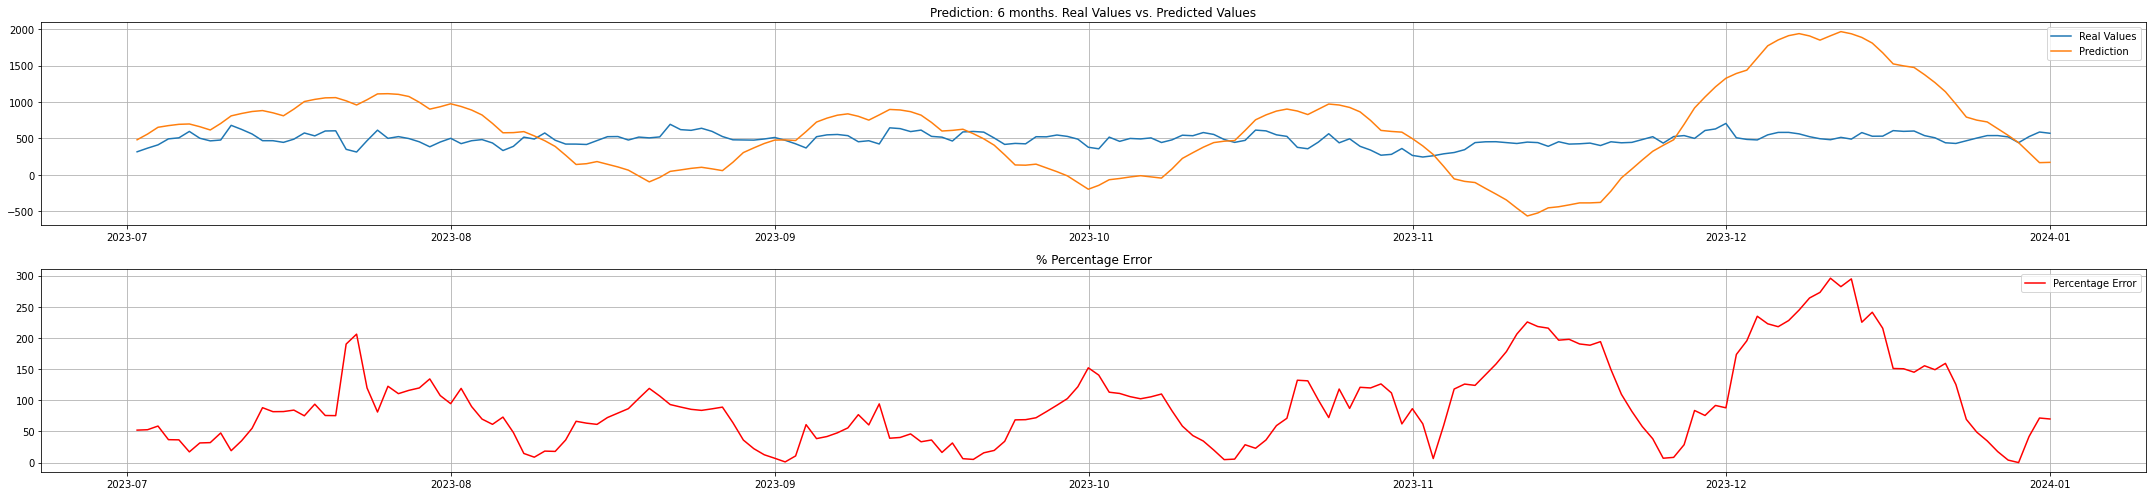


DATASET: 6 months; Error calculation:          
1 WEEK:          %Mean.Abs.Perc.Err: 40.78                          
2 WEEKS:          %Mean.Abs.Perc.Err: 46.00                              
1 MONTH:          %Mean.Abs.Perc.Err: 81.23                                   
2 MONTHS:          %Mean.Abs.Perc.Err: 74.93                             
6 MONTHS:          %Mean.Abs.Perc.Err: 93.68


In [9]:
datasets = [dataset_30m, dataset_28m, dataset_26m, dataset_24m, dataset_22m, dataset_20m,
dataset_18m, dataset_16m, dataset_14m, dataset_12m, dataset_10m, dataset_8m, dataset_6m]

errordf = pd.DataFrame(columns=['1w', '2w', '4w', '1m', '2m', '6m'])

for dataset in datasets:
     m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
     m.fit(dataset)
     future = m.make_future_dataframe(periods=184) # Half a year of prediction
     forecast = m.predict(future)
     real_val = dataset_CI_fix[(dataset_CI_fix['ds'] > '2023-07')]
     real_val = real_val[(real_val['ds'].dt.hour == 23)]
     real_val = real_val.reset_index()

     pred_val = forecast[(forecast['ds'] > '2023-07')]
     pred_val = pred_val['yhat'].reset_index()

     dataset_zoom = pd.concat([real_val, pred_val], axis = 1)
     dataset_zoom.drop(columns=['index'], inplace = True)
     dataset_zoom.columns = ['Timestamp', 'Real Values', 'Prediction']
     dataset_zoom = dataset_zoom.set_index('Timestamp')
     dataset_zoom

     dataset_zoom['percerr_graph'] = (abs(dataset_zoom['Prediction']-dataset_zoom['Real Values'])/dataset_zoom['Real Values'])*100
     errordf.loc[dataset.name] = [100*mean_absolute_percentage_error(dataset_zoom[0:7]['Real Values'], dataset_zoom[0:7]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:14]['Real Values'], dataset_zoom[0:14]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:21]['Real Values'], dataset_zoom[0:21]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:30]['Real Values'], dataset_zoom[0:30]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:60]['Real Values'], dataset_zoom[0:60]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom['Real Values'], dataset_zoom['Prediction'])] 

     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

     ax1.plot(dataset_zoom.index, dataset_zoom['Real Values'], label='Real Values')
     ax1.plot(dataset_zoom.index, dataset_zoom['Prediction'], label='Prediction')
     ax1.set_title(f"Prediction: {dataset.name}. Real Values vs. Predicted Values")
     ax1.grid()
     ax1.legend()


     ax2.plot(dataset_zoom.index, dataset_zoom['percerr_graph'], 'red', label = 'Percentage Error')
     ax2.set_title(f"% Percentage Error")
     ax2.grid()
     ax2.legend()

     plt.tight_layout()
     plt.show()

     # ERROR print: uncomment to print:
     print(f"\nDATASET: {dataset.name}; Error calculation:\
          \n1 WEEK:\
          %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:7]['Real Values'], dataset_zoom[0:7]['Prediction']):.2f}                \
          \n2 WEEKS:\
          %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:14]['Real Values'], dataset_zoom[0:14]['Prediction']):.2f}                    \
          \n1 MONTH:\
          %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:30]['Real Values'], dataset_zoom[0:30]['Prediction']):.2f}                         \
          \n2 MONTHS:\
          %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:60]['Real Values'], dataset_zoom[0:60]['Prediction']):.2f}                   \
          \n6 MONTHS:\
          %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom['Real Values'], dataset_zoom['Prediction']):.2f}")



In [10]:
errordf

,1w,2w,4w,1m,2m,6m
30 months,21.866114,16.213855,15.370385,16.961522,17.605573,36.454471
28 months,24.525556,18.587784,18.896751,22.046147,24.939053,64.088366
26 months,21.706071,16.250069,15.636854,17.565388,17.763283,45.473546
24 months,21.057005,15.748774,15.017474,17.049124,18.265705,41.544689
22 months,21.185147,15.499026,14.294168,15.552252,17.095479,39.699679
20 months,20.433265,15.095615,13.982779,15.118956,16.136720,30.613654
18 months,20.925214,15.528795,14.261329,15.197130,17.108947,34.959615
16 months,22.355207,16.786480,16.595772,19.335226,25.683237,62.257460
14 months,19.821591,14.821220,13.326473,14.108928,16.030849,34.137728
12 months,26.711256,20.874966,21.512462,24.174571,27.175484,44.508729


In [11]:
errordf.min()

1w    19.821591
2w    14.821220
4w    13.326473
1m    14.108928
2m    16.030849
6m    30.613654
dtype: float64

14 month training period + 4 week prediction (28days)

14:33:13 - cmdstanpy - INFO - Chain [1] start processing
14:33:17 - cmdstanpy - INFO - Chain [1] done processing


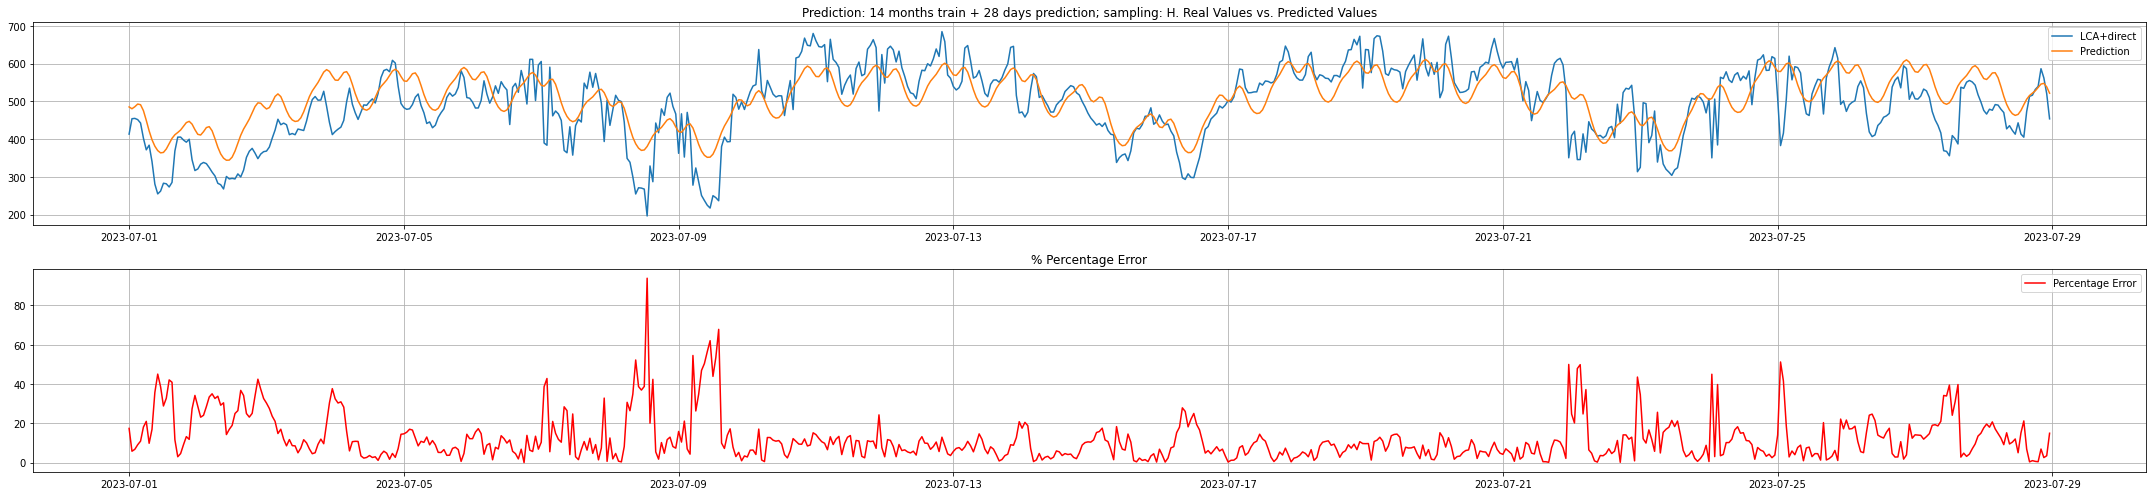

%error H: 12.07 


14:33:22 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing


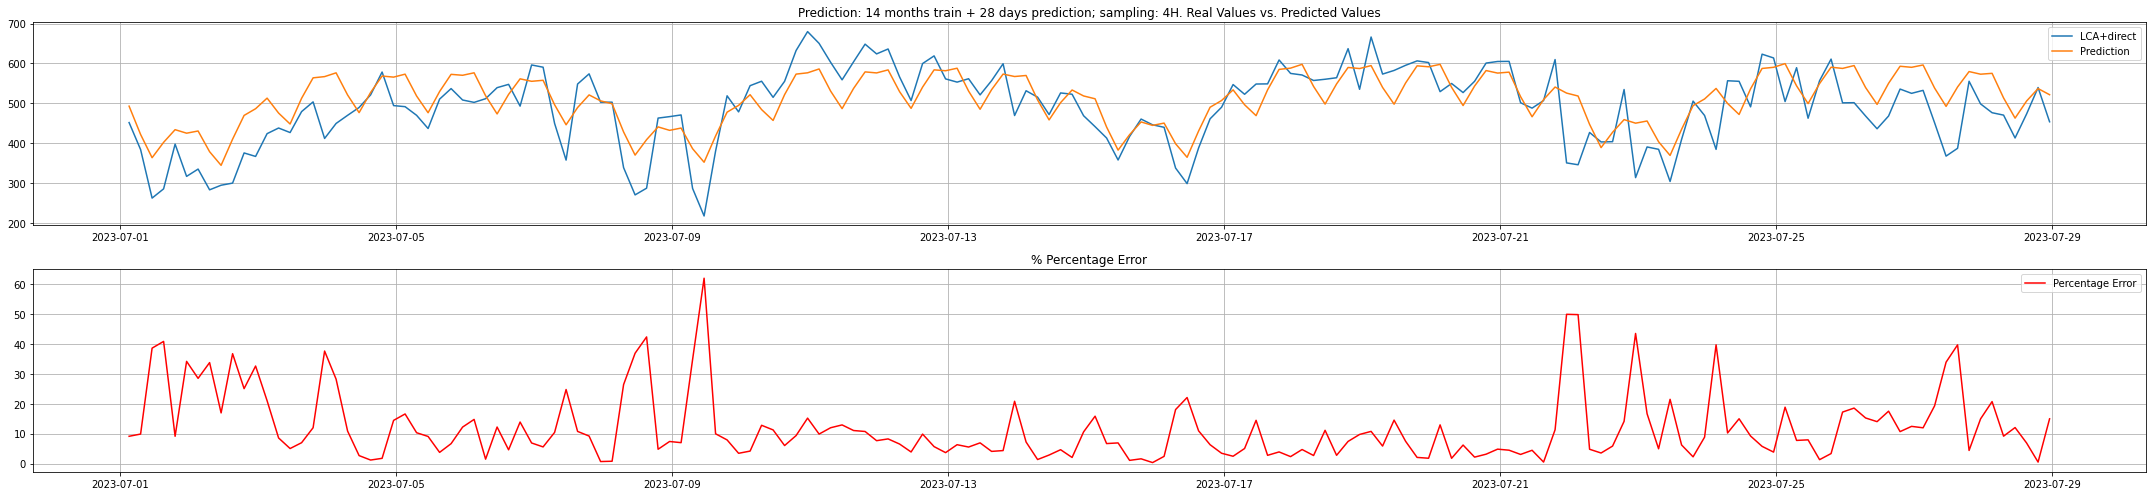

%error 4H: 12.10 


14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1] done processing


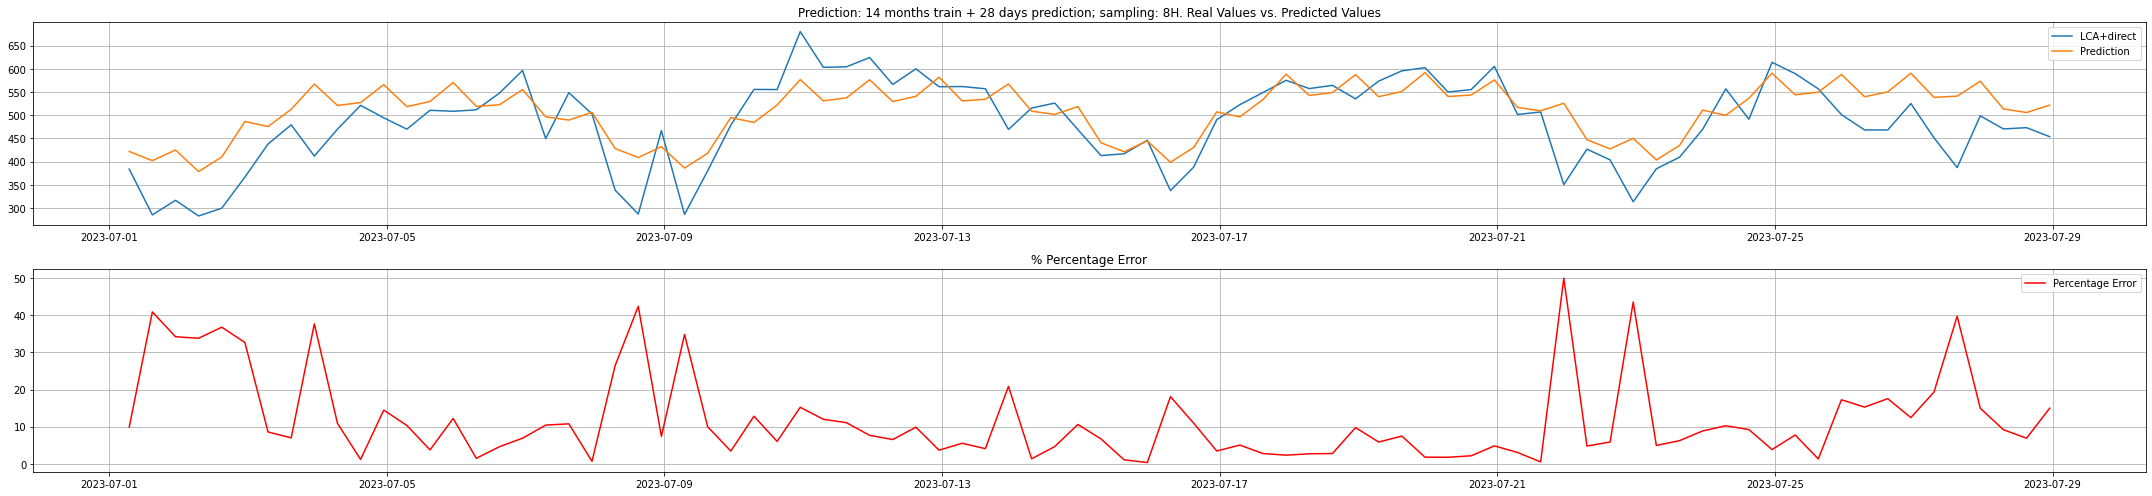

%error 8H: 11.93 


14:33:36 - cmdstanpy - INFO - Chain [1] start processing
14:33:39 - cmdstanpy - INFO - Chain [1] done processing


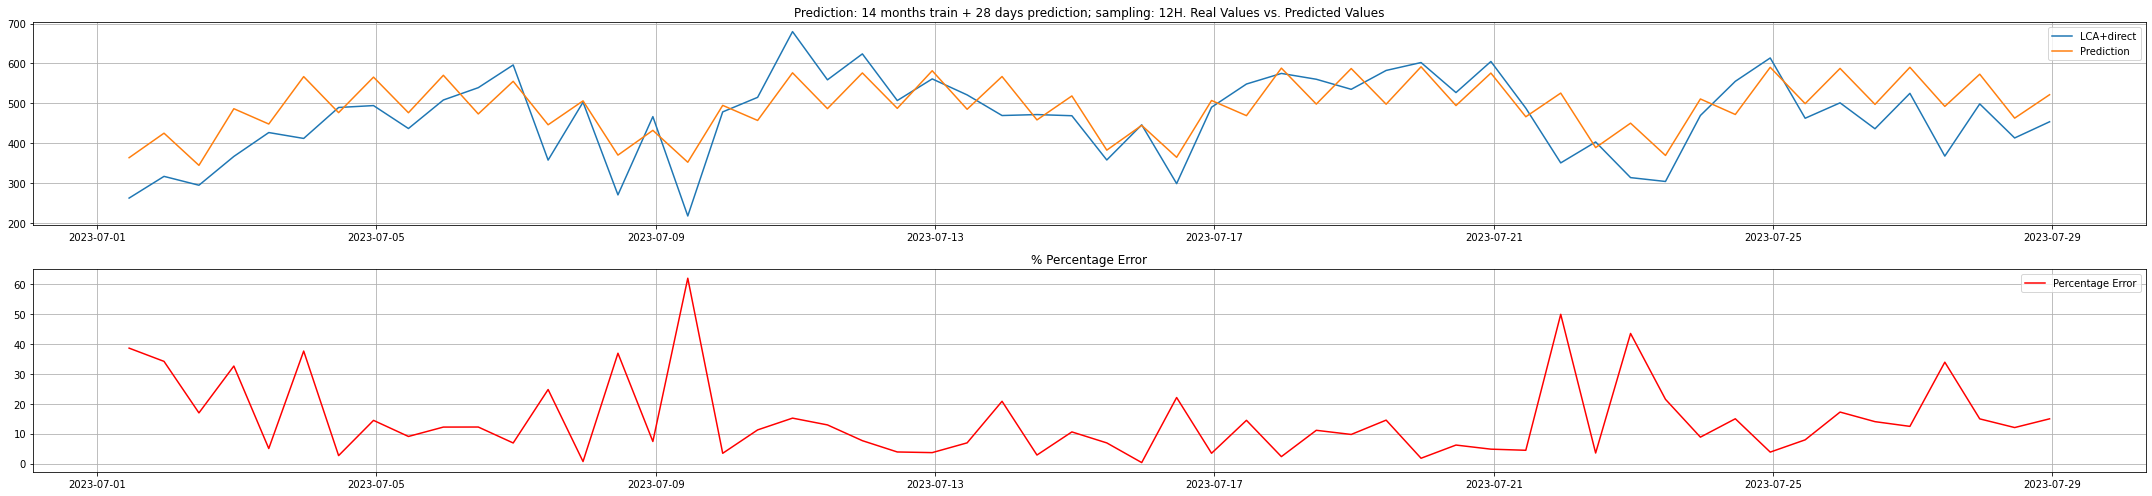

%error 12H: 14.82 


In [12]:
periods = {'H': 28*24, '4H': 28*6, '8H': 28*3, '12H': 28*2}
freqs = ['H', '4H', '8H', '12H']

for freq_s in freqs:
    #print(periods[freq])

    model = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True)
    # Fit the model on historical data
    model.fit(dataset_14m)

    future = model.make_future_dataframe(periods=periods[freq_s], freq=freq_s)
    forecast = model.predict(future)

    dataset_copy = dataset_CI[21864:]
    forecast_copy = forecast[10223:]

    forecast_copy.set_index('ds', inplace=True)
    df_aligned = dataset_copy[dataset_copy.index.isin(forecast_copy.index)]
    df_combined = df_aligned.join(forecast_copy, lsuffix='_hourly', rsuffix='_resampled')

    df_combined['percerr_graph'] = (abs((df_combined['yhat']-df_combined['LCA+direct'])/df_combined['LCA+direct']))*100


    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

    ax1.plot(df_combined.index, df_combined['LCA+direct'], label='LCA+direct')
    ax1.plot(df_combined.index, df_combined['yhat'], label='Prediction')
    ax1.set_title(f"Prediction: 14 months train + 28 days prediction; sampling: {freq_s}. Real Values vs. Predicted Values")
    ax1.grid()
    ax1.legend()


    ax2.plot(df_combined.index, df_combined['percerr_graph'], 'red', label = 'Percentage Error')
    ax2.set_title(f"% Percentage Error")
    ax2.grid()
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"%error {freq_s}: {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['yhat']):.2f} ")

12:53:37 - cmdstanpy - INFO - Chain [1] start processing
12:53:41 - cmdstanpy - INFO - Chain [1] done processing


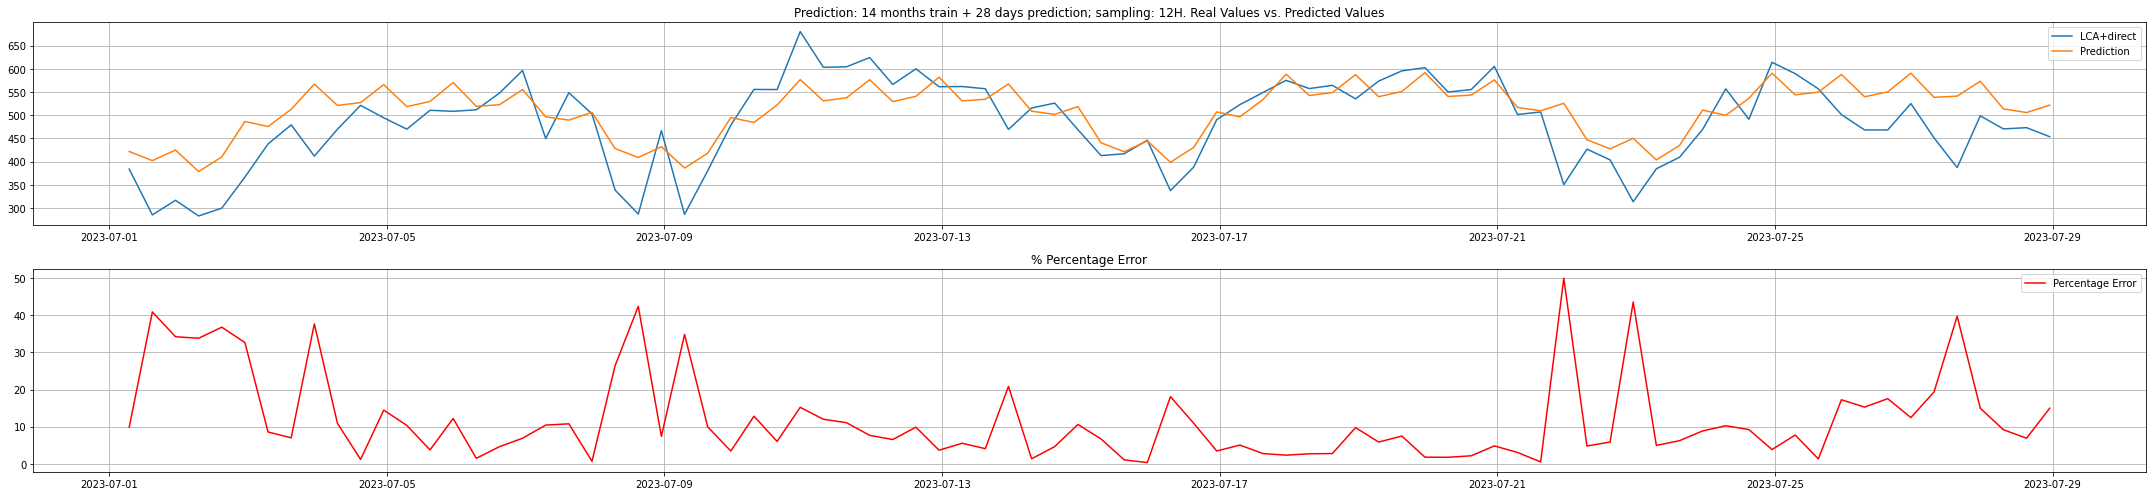

%error 12H: 11.93 


In [20]:
model = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True)
# Fit the model on historical data
model.fit(dataset_14m)

future = model.make_future_dataframe(periods=28*3, freq='8H')
forecast = model.predict(future)

dataset_copy = dataset_CI[21864:]
forecast_copy = forecast[10223:]

forecast_copy.set_index('ds', inplace=True)
df_aligned = dataset_copy[dataset_copy.index.isin(forecast_copy.index)]
df_combined = df_aligned.join(forecast_copy, lsuffix='_hourly', rsuffix='_resampled')

df_combined['percerr_graph'] = (abs((df_combined['yhat']-df_combined['LCA+direct'])/df_combined['LCA+direct']))*100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

ax1.plot(df_combined.index, df_combined['LCA+direct'], label='LCA+direct')
ax1.plot(df_combined.index, df_combined['yhat'], label='Prediction')
ax1.set_title(f"Prediction: 14 months train + 28 days prediction; sampling: 8H. Real Values vs. Predicted Values")
ax1.grid()
ax1.legend()

ax2.plot(df_combined.index, df_combined['percerr_graph'], 'red', label = 'Percentage Error')
ax2.set_title(f"% Percentage Error")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

print(f"%error 8H: {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['yhat']):.2f} ")

Parameters that can be tuned

    changepoint_prior_scale: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

    seasonality_prior_scale: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

In [84]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'yearly_seasonality' : [True], 
    'weekly_seasonality' : [True], 
    'daily_seasonality' : [True],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
errordf = pd.DataFrame(columns=['err%'])


for params in all_params:
    model = Prophet(**params)
    # Fit the model on historical data
    model.fit(dataset_14m)

    future = model.make_future_dataframe(periods=28, freq='D')
    forecast = model.predict(future)

    dataset_copy = dataset_CI[21864:]
    forecast_copy = forecast[10223:]

    forecast_copy.set_index('ds', inplace=True)
    df_aligned = dataset_copy[dataset_copy.index.isin(forecast_copy.index)]
    df_combined = df_aligned.join(forecast_copy, lsuffix='_hourly', rsuffix='_resampled')

#    df_combined['percerr_graph'] = (abs((df_combined['yhat']-df_combined['LCA+direct'])/df_combined['LCA+direct']))*100

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

    # ax1.plot(df_combined.index, df_combined['LCA+direct'], label='LCA+direct')
    # ax1.plot(df_combined.index, df_combined['yhat'], label='Prediction')
    # ax1.set_title(f"Prediction: 14 months train + 28 days prediction; sampling: {freq_s}. Real Values vs. Predicted Values")
    # ax1.grid()
    # ax1.legend()

    # ax2.plot(df_combined.index, df_combined['percerr_graph'], 'red', label = 'Percentage Error')
    # ax2.set_title(f"% Percentage Error")
    # ax2.grid()
    # ax2.legend()

    # plt.tight_layout()
    # plt.show()

    #print(f"%error {freq_s}: {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['yhat']):.2f} ")
    errordf.loc[f"{params}"] = 100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['yhat'])

errordf


15:36:39 - cmdstanpy - INFO - Chain [1] start processing
15:36:40 - cmdstanpy - INFO - Chain [1] done processing
15:36:43 - cmdstanpy - INFO - Chain [1] start processing
15:36:44 - cmdstanpy - INFO - Chain [1] done processing
15:36:47 - cmdstanpy - INFO - Chain [1] start processing
15:36:48 - cmdstanpy - INFO - Chain [1] done processing
15:36:51 - cmdstanpy - INFO - Chain [1] start processing
15:36:53 - cmdstanpy - INFO - Chain [1] done processing
15:36:56 - cmdstanpy - INFO - Chain [1] start processing
15:36:57 - cmdstanpy - INFO - Chain [1] done processing
15:37:00 - cmdstanpy - INFO - Chain [1] start processing
15:37:01 - cmdstanpy - INFO - Chain [1] done processing
15:37:04 - cmdstanpy - INFO - Chain [1] start processing
15:37:05 - cmdstanpy - INFO - Chain [1] done processing
15:37:08 - cmdstanpy - INFO - Chain [1] start processing
15:37:09 - cmdstanpy - INFO - Chain [1] done processing
15:37:13 - cmdstanpy - INFO - Chain [1] start processing
15:37:20 - cmdstanpy - INFO - Chain [1]

,err%
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.8, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}",12.294727
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.8, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}",12.223743
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.8, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}",12.318697
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.8, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}",12.258328
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.8, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}",12.481813
...,...
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.95, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}",26.626362
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.95, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}",25.958720
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.95, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}",28.547824
"{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.95, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}",41.476506


In [93]:
errordf.min()

err%    12.223743
dtype: float64

In [94]:
value_to_find = 12.223743 == 12.223743
indices = errordf.stack()[errordf.stack() == value_to_find].index.tolist()
print(indices)

[]


In [87]:
errordf[errordf['err%'] == 10.852888].index.tolist()

[]

{'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_range': 0.95, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0} - err%: 10.85267%

15:48:44 - cmdstanpy - INFO - Chain [1] start processing
15:48:45 - cmdstanpy - INFO - Chain [1] done processing


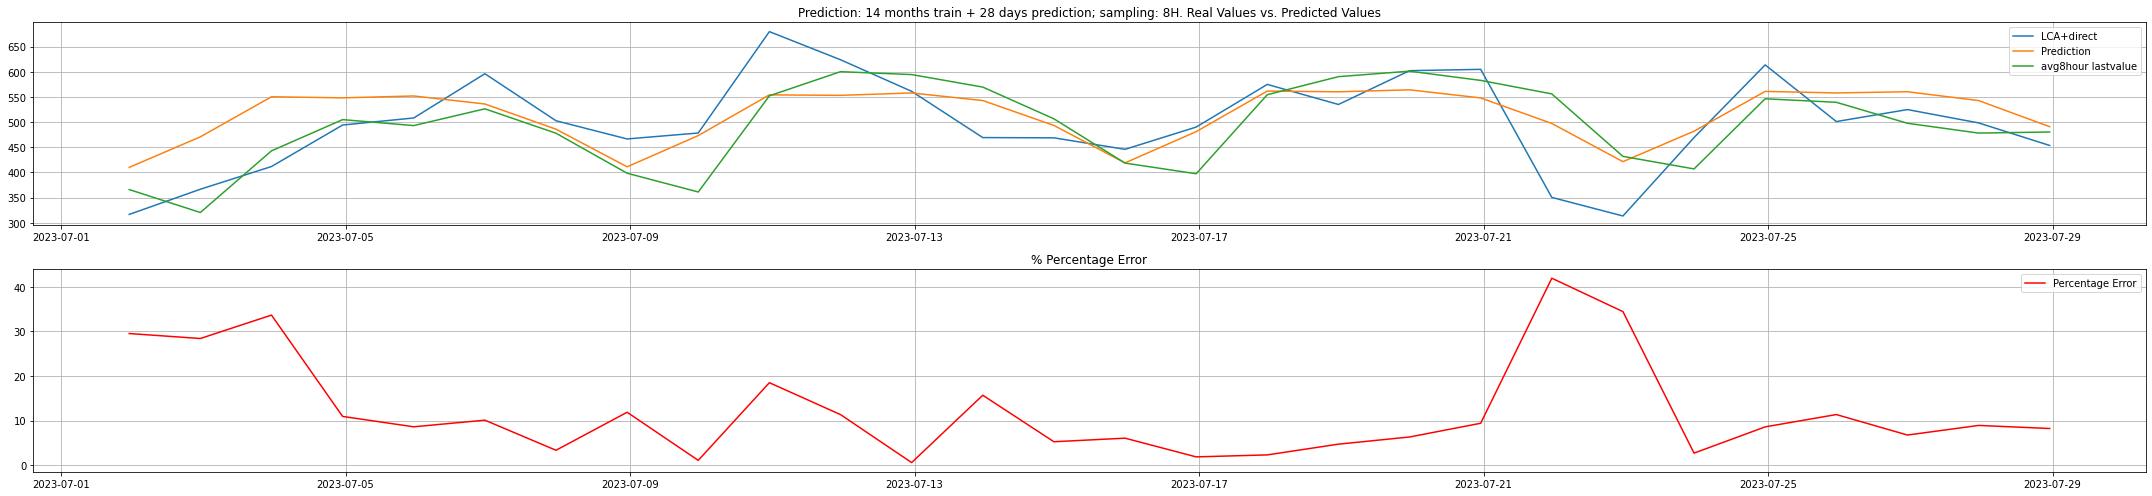

%error 4H: 12.22 
%error 4Havglastval: 12.17 


In [95]:
def generate_moving_average_predictions(df, window_size):
    predictions = []
    for i in range(len(df)):
        if i < window_size:
            # Not enough data points for a full window, append None
            predictions.append(None)
        else:
            # Prediction is the average of the last 'window_size' values
            window_avg = df['LCA+direct'][i-window_size:i].mean()
            predictions.append(window_avg)
    return predictions

model = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True, changepoint_range = 0.8, changepoint_prior_scale = 0.001, seasonality_prior_scale = 0.1)
# Fit the model on historical data
model.fit(dataset_14m)

future = model.make_future_dataframe(periods=28, freq='D')
forecast = model.predict(future)

dataset_CI['avg8hrs'] =  generate_moving_average_predictions(dataset_CI, 24)
dataset_copy = dataset_CI[21864:]
forecast_copy = forecast[10223:]

forecast_copy.set_index('ds', inplace=True)
df_aligned = dataset_copy[dataset_copy.index.isin(forecast_copy.index)]
df_combined = df_aligned.join(forecast_copy, lsuffix='_hourly', rsuffix='_resampled')

df_combined['percerr_graph'] = (abs((df_combined['yhat']-df_combined['LCA+direct'])/df_combined['LCA+direct']))*100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

ax1.plot(df_combined.index, df_combined['LCA+direct'], label='LCA+direct')
ax1.plot(df_combined.index, df_combined['yhat'], label='Prediction')
ax1.plot(df_combined.index, df_combined['avg8hrs'], label='avg8hour lastvalue')
ax1.set_title(f"Prediction: 14 months train + 28 days prediction; sampling: 8H. Real Values vs. Predicted Values")
ax1.grid()
ax1.legend()

ax2.plot(df_combined.index, df_combined['percerr_graph'], 'red', label = 'Percentage Error')
ax2.set_title(f"% Percentage Error")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

print(f"%error 4H: {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['yhat']):.2f} ")
print(f"%error 4Havglastval: {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['avg8hrs']):.2f} ")

In [ ]:
dataset_30m = dataset_CI_fix[(dataset_CI_fix['ds'] < '2023-07')] # 2.5 years of data = 30 months
dataset_28m = dataset_30m[(dataset_30m['ds'] > '2021-03')]
dataset_26m = dataset_28m[(dataset_28m['ds'] > '2021-05')]
dataset_24m = dataset_26m[(dataset_26m['ds'] > '2021-07')]
dataset_22m = dataset_24m[(dataset_24m['ds'] > '2021-09')]
dataset_20m = dataset_22m[(dataset_22m['ds'] > '2021-11')]
dataset_18m = dataset_20m[(dataset_20m['ds'] > '2022-01')]
dataset_16m = dataset_18m[(dataset_18m['ds'] > '2022-03')]
dataset_14m = dataset_16m[(dataset_16m['ds'] > '2022-05')]
dataset_12m = dataset_14m[(dataset_14m['ds'] > '2022-07')] 
dataset_10m = dataset_12m[(dataset_12m['ds'] > '2022-09')] 

dataset_30m.name = "30 months"
dataset_28m.name = "28 months"
dataset_26m.name = "26 months" 
dataset_24m.name = "24 months"
dataset_22m.name = "22 months"
dataset_20m.name = "20 months"
dataset_18m.name = "18 months"
dataset_16m.name = "16 months"
dataset_14m.name = "14 months"
dataset_12m.name = "12 months"
dataset_10m.name = "10 months"

In [98]:
# another testzone: different lenghts + param play

In [106]:
datasets = [dataset_30m, dataset_28m, dataset_26m, dataset_24m, dataset_22m, dataset_20m, dataset_18m, dataset_16m, dataset_14m, dataset_12m]

errordf = pd.DataFrame(columns=['1w', '2w', '4w', '1m', '2m', '6m'])

param_grid = {  
    'yearly_seasonality' : [True], 
    'weekly_seasonality' : [True], 
    'daily_seasonality' : [True],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for dataset in datasets:
     for params in all_params: 
          m = Prophet(**params)      # forcing to consider seasonality
          m.fit(dataset)
          future = m.make_future_dataframe(periods=184) # Half a year of prediction
          forecast = m.predict(future)

          real_val = dataset_CI_fix[(dataset_CI_fix['ds'] > '2023-07')]
          real_val = real_val[(real_val['ds'].dt.hour == 23)]
          real_val = real_val.reset_index()

          pred_val = forecast[(forecast['ds'] > '2023-07')]
          pred_val = pred_val['yhat'].reset_index()

          dataset_zoom = pd.concat([real_val, pred_val], axis = 1)
          dataset_zoom.drop(columns=['index'], inplace = True)
          dataset_zoom.columns = ['Timestamp', 'Real Values', 'Prediction']
          dataset_zoom = dataset_zoom.set_index('Timestamp')
          dataset_zoom

          dataset_zoom['percerr_graph'] = (abs(dataset_zoom['Prediction']-dataset_zoom['Real Values'])/dataset_zoom['Real Values'])*100
          errordf.loc[f"{dataset.name} + {params}"] = [100*mean_absolute_percentage_error(dataset_zoom[0:7]['Real Values'], dataset_zoom[0:7]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:14]['Real Values'], dataset_zoom[0:14]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:21]['Real Values'], dataset_zoom[0:21]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:30]['Real Values'], dataset_zoom[0:30]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom[0:60]['Real Values'], dataset_zoom[0:60]['Prediction']), 100*mean_absolute_percentage_error(dataset_zoom['Real Values'], dataset_zoom['Prediction'])] 

          del(real_val)
          del(pred_val)
          del(dataset_zoom)

errordf

     # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

     # ax1.plot(dataset_zoom.index, dataset_zoom['Real Values'], label='Real Values')
     # ax1.plot(dataset_zoom.index, dataset_zoom['Prediction'], label='Prediction')
     # ax1.set_title(f"Prediction: {dataset.name}. Real Values vs. Predicted Values")
     # ax1.grid()
     # ax1.legend()


     # ax2.plot(dataset_zoom.index, dataset_zoom['percerr_graph'], 'red', label = 'Percentage Error')
     # ax2.set_title(f"% Percentage Error")
     # ax2.grid()
     # ax2.legend()

     # plt.tight_layout()
     # plt.show()

     # # ERROR print: uncomment to print:
     # print(f"\nDATASET: {dataset.name}; Error calculation:\
     #      \n1 WEEK:\
     #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:7]['Real Values'], dataset_zoom[0:7]['Prediction']):.2f}                \
     #      \n2 WEEKS:\
     #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:14]['Real Values'], dataset_zoom[0:14]['Prediction']):.2f}                    \
     #      \n1 MONTH:\
     #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:30]['Real Values'], dataset_zoom[0:30]['Prediction']):.2f}                         \
     #      \n2 MONTHS:\
     #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom[0:60]['Real Values'], dataset_zoom[0:60]['Prediction']):.2f}                   \
     #      \n6 MONTHS:\
     #      %Mean.Abs.Perc.Err: {100*mean_absolute_percentage_error(dataset_zoom['Real Values'], dataset_zoom['Prediction']):.2f}")



16:01:05 - cmdstanpy - INFO - Chain [1] start processing
16:01:08 - cmdstanpy - INFO - Chain [1] done processing
16:01:14 - cmdstanpy - INFO - Chain [1] start processing
16:01:17 - cmdstanpy - INFO - Chain [1] done processing
16:01:24 - cmdstanpy - INFO - Chain [1] start processing
16:01:27 - cmdstanpy - INFO - Chain [1] done processing
16:01:34 - cmdstanpy - INFO - Chain [1] start processing
16:01:37 - cmdstanpy - INFO - Chain [1] done processing
16:01:43 - cmdstanpy - INFO - Chain [1] start processing
16:01:52 - cmdstanpy - INFO - Chain [1] done processing
16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:27 - cmdstanpy - INFO - Chain [1] done processing
16:02:36 - cmdstanpy - INFO - Chain [1] start processing
16:02:46 - cmdstanpy - INFO - Chain [1] done processing
16:02:52 - cmdstanpy - INFO - Chain [1] start processing
16:03:13 - cmdstanpy - INFO - Chain [1]

,1w,2w,4w,1m,2m,6m
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}",13.630485,13.280979,13.799278,12.413116,12.352720,20.469702
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}",13.530206,13.325199,13.882502,12.535719,12.518239,20.476328
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}",13.515818,13.331933,13.895619,12.554807,12.542607,20.451458
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}",13.563151,13.297227,13.834410,12.468842,12.432500,20.525115
"30 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}",16.885871,13.091157,12.126686,11.247302,10.661873,24.894415
...,...,...,...,...,...,...
"12 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}",41.511412,43.383555,55.920250,76.480953,127.926353,364.544863
"12 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}",30.437194,24.556564,24.910249,25.091290,19.354788,20.990450
"12 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}",36.277025,33.747193,39.399486,47.661091,61.834044,112.269836
"12 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}",48.963112,56.115529,75.330757,105.650157,192.688530,591.036954


In [113]:
errordf.min()


1w    13.331696
2w    13.091157
4w    12.105791
1m    10.831197
2m    10.309345
6m    14.486711
dtype: float64

In [115]:
errordf['2m'].idxmin()

"16 months + {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}"

In [116]:
errordf['2m'].min()


10.309344970639916

17:23:09 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing


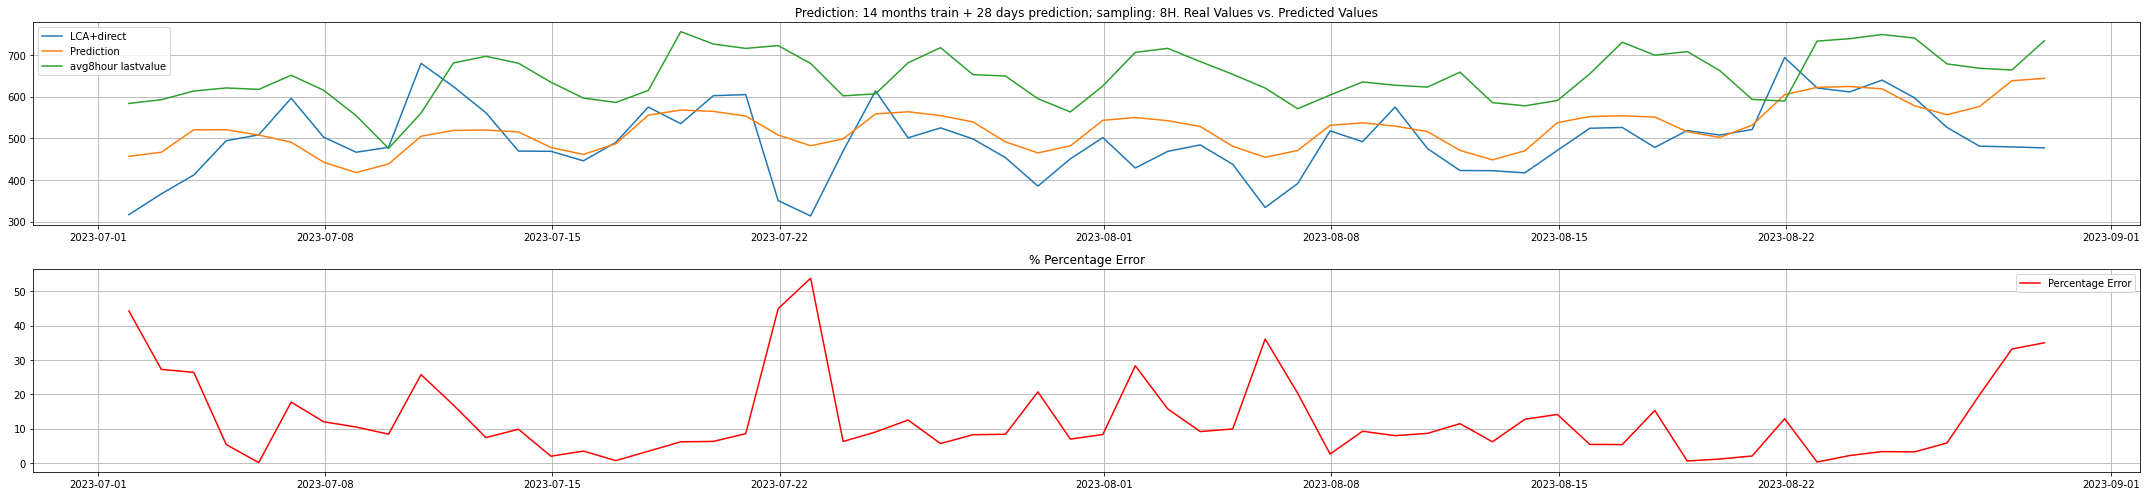

%error 4H: 12.73 
%error 4Havglastval: 34.99 


In [146]:

def generate_moving_average_predictions(df, window_size):
    predictions = []
    for i in range(len(df)):
        if i < window_size:
            # Not enough data points for a full window, append None
            predictions.append(None)
        else:
            # Prediction is the average of the last 'window_size' values
            window_avg = df['LCA+direct'][i-window_size:i].mean()
            predictions.append(window_avg)
    return predictions

def generate_pred(df):
    pred = []
    for i in range(1, len(df)):
        # The prediction for the current value is the previous actual value
        pred.append(df['LCA+direct'].iloc[i-1])
    
    # Add None for the first value as it has no previous value to predict from
    pred = [None] + pred
    return pred

def seasonal_naive_pred(df):
    pred = []
    for i in range(1, len(df)):
        # Get the timestamp of one year before the current timestamp
        prev_year_timestamp = df.index[i - 1] - pd.DateOffset(years=1)
        
        # Search for the row in the dataframe with the timestamp of one year before
        # If the timestamp doesn't exist in the dataframe, return None
        if prev_year_timestamp not in df.index:
            pred.append(None)
        else:
            # Get the value from the same timestamp one year before
            pred.append(df.loc[prev_year_timestamp, 'LCA+direct'])
    
    # Add None for the first value as it has no previous value to predict from
    pred = [None] + pred
    return pred

model = Prophet(yearly_seasonality = 20, weekly_seasonality=10, daily_seasonality=20, changepoint_range = 0.8, changepoint_prior_scale = 0.001, seasonality_prior_scale = 0.1)
# Fit the model on historical data
model.fit(dataset_16m)

future = model.make_future_dataframe(periods=60, freq='D')
forecast = model.predict(future)

#dataset_CI['avg8hrs'] =  generate_moving_average_predictions(dataset_CI, 24)
#dataset_CI['avg8hrs'] =  generate_pred(dataset_CI)
#dataset_CI['avg8hrs'] = seasonal_naive_pred(dataset_CI, 365*24)

dataset_CI['avg8hrs'] = seasonal_naive_pred(dataset_CI)

dataset_copy = dataset_CI[21864:]
forecast_copy = forecast[10223:]

forecast_copy.set_index('ds', inplace=True)
df_aligned = dataset_copy[dataset_copy.index.isin(forecast_copy.index)]
df_combined = df_aligned.join(forecast_copy, lsuffix='_hourly', rsuffix='_resampled')

df_combined['percerr_graph'] = (abs((df_combined['yhat']-df_combined['LCA+direct'])/df_combined['LCA+direct']))*100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 7))

ax1.plot(df_combined.index, df_combined['LCA+direct'], label='LCA+direct')
ax1.plot(df_combined.index, df_combined['yhat'], label='Prediction')
ax1.plot(df_combined.index, df_combined['avg8hrs'], label='avg8hour lastvalue')
ax1.set_title(f"Prediction: 14 months train + 28 days prediction; sampling: 8H. Real Values vs. Predicted Values")
ax1.grid()
ax1.legend()

ax2.plot(df_combined.index, df_combined['percerr_graph'], 'red', label = 'Percentage Error')
ax2.set_title(f"% Percentage Error")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

print(f"%error 4H: {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['yhat']):.2f} ")
print(f"%error 4Havglastval: {100*mean_absolute_percentage_error(df_combined['LCA+direct'], df_combined['avg8hrs']):.2f} ")